# Imports

In [1]:
import torch
import cv2
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import random

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from itertools import islice
from copy import copy

np.random.seed(42)

# Utils

In [2]:
plt.rcParams['figure.figsize'] = [5, 5]

In [3]:
def plot_image(img: np.ndarray, cmap: str=None, title: str=None, fig_size: tuple=None):
    fig = plt.figure(1)
    ax1 = fig.add_subplot()
    if cmap:
        ax1.imshow(img, cmap, vmin=0, vmax=255)
    else:
        ax1.imshow(img, vmin=0, vmax=255)
    if title:
        ax1.set_title(title)
    if fig_size:
        fig.set_figheight(fig_size[0])
        fig.set_figwidth(fig_size[1])
    plt.show()


def subplot_images(images_dict: dict[np.ndarray], num_img_in_row: int, cmap: str=None, title=None, suptitle: str=None, fig_size: tuple=None):
    n_images = len(images_dict.values())
    nrows = (n_images // num_img_in_row) + 1
    ncols = num_img_in_row
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    if fig_size:
        fig.set_figheight(fig_size[0])
        fig.set_figwidth(fig_size[1])
    else:
        fig.set_figwidth(5 * n_images)
        fig.set_figheight(10)
    if suptitle:
        fig.suptitle(suptitle, fontsize=5 * n_images)

    for i, (t, img) in enumerate(images_dict.items()):
        row_index = i // num_img_in_row
        col_index = i % num_img_in_row
        axs[row_index][col_index].imshow(img, cmap=cmap, vmin=0, vmax=255)
        if title:
            axs[row_index][col_index].set_title(title + str(t), {'fontsize': 5 * n_images})

    # Remove spare columns
    num_spare = nrows * ncols - n_images
    for i in range(num_img_in_row - num_spare, num_img_in_row):
        fig.delaxes(axs[nrows - 1][i])

    plt.show()


def subplot_n_images_from_dataset(images_class_dict: dict, num_to_plot_from_each: int, cmap: str=None):
    n = len(images_class_dict)

    for i in range(n):
        sub_images_dict = images_class_dict[i]
        images_dict = {j:image for (j, image) in islice(sub_images_dict.items(), num_to_plot_from_each)}
        subplot_images(images_dict, num_to_plot_from_each, cmap, 'Image Index = ', f"Label = {i}")


# MNIST

### Global Variables

In [4]:
mnist_train_data = torchvision.datasets.MNIST('/Users/noyhanan/Dev/Computer_Vision/Datasets', 
                                              train=True, download=True)
mnist_train_images = mnist_train_data.data.numpy()
mnist_train_labels = mnist_train_data.targets.numpy()

In [5]:
mnist_train_test = torchvision.datasets.MNIST('/Users/noyhanan/Dev/Computer_Vision/Datasets', 
                                              train=False, download=True)

### Dataset info

In [6]:
print(mnist_train_images.shape) #60K Images with Dimension 28X28
print(f"There are {len(mnist_train_data.classes)} which are {mnist_train_data.classes}")

(60000, 28, 28)
There are 10 which are ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


### 1.1 - Plot 5 examples of each class

In [7]:
def create_dict_of_dataset_classes(dataset: Dataset) -> dict:
    num_classes = len(dataset.classes)
    data_size = dataset.data.shape[0]

    # initilize images class dictionary
    images_class_dict = {i: {} for i in range(num_classes)}

    for i in range(data_size):
        item = mnist_train_data[i]
        images_class_dict[item[1]][i] = item[0]

    return images_class_dict

In [8]:
num_to_plot_from_each = 6
images_class_dict = create_dict_of_dataset_classes(mnist_train_data)

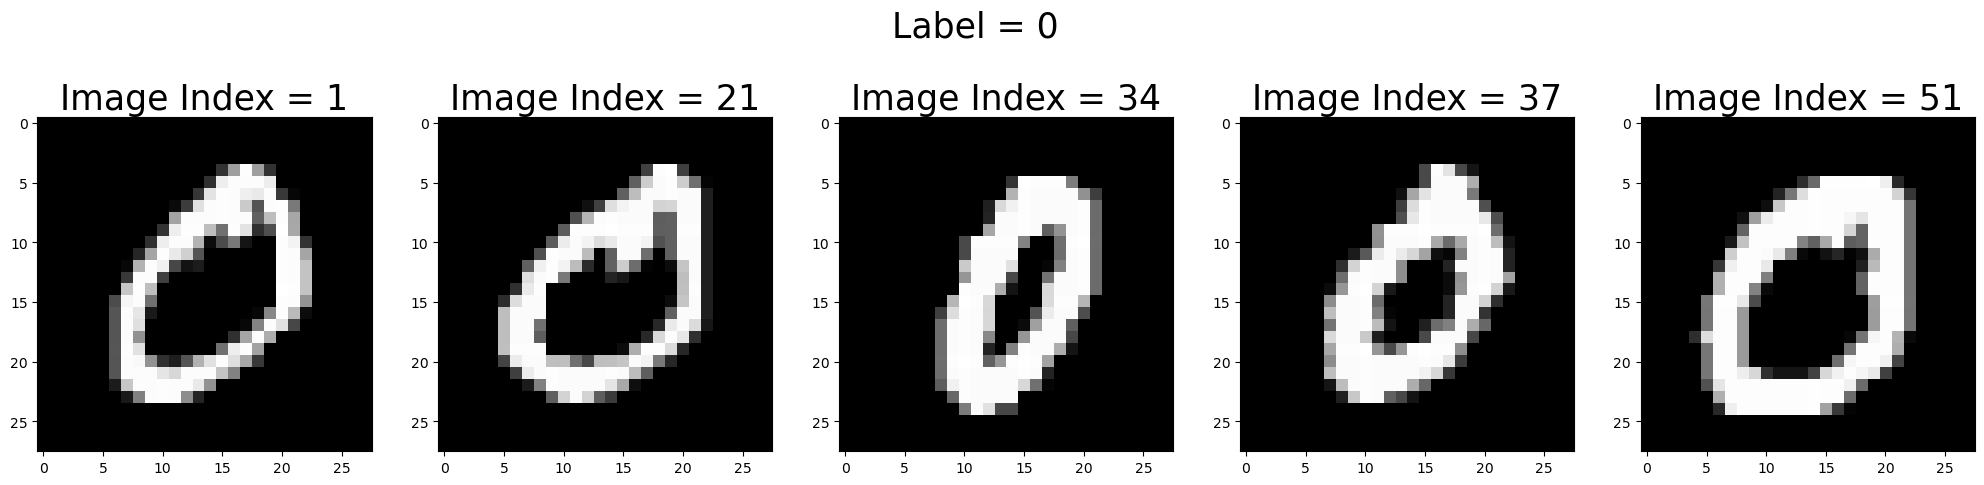

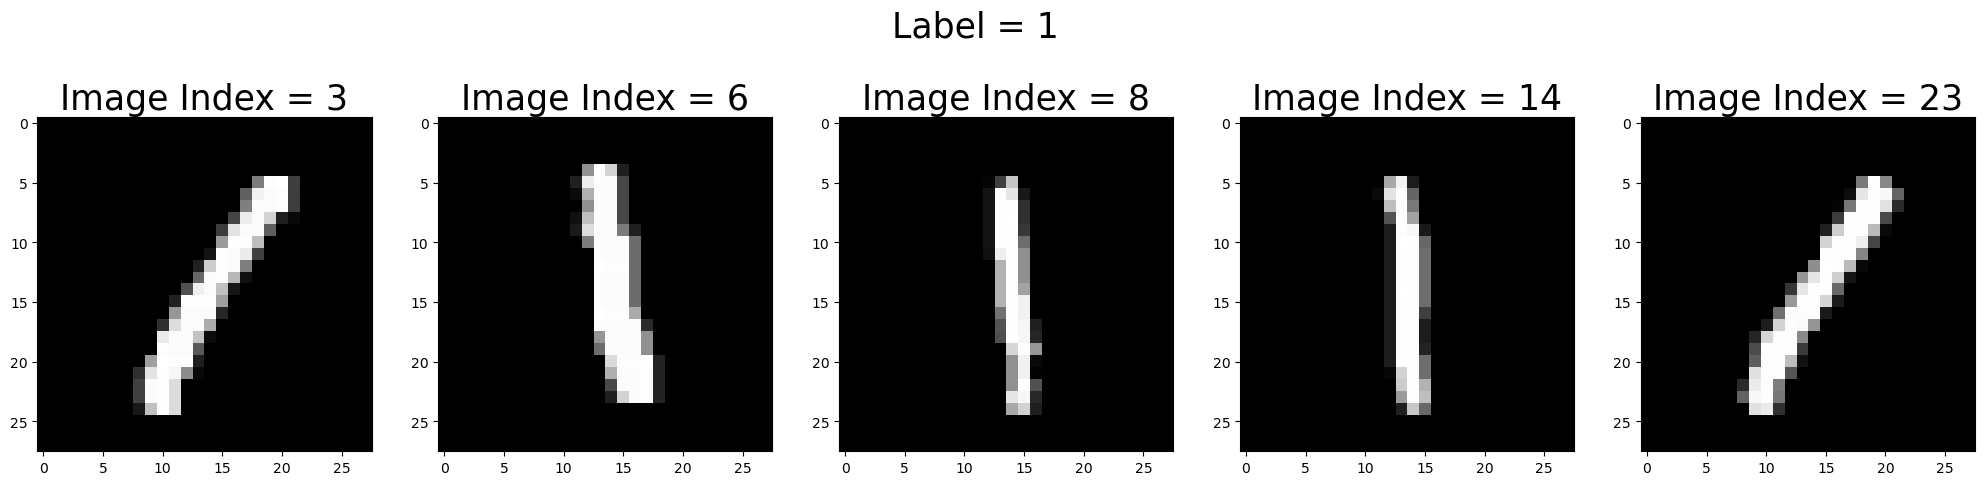

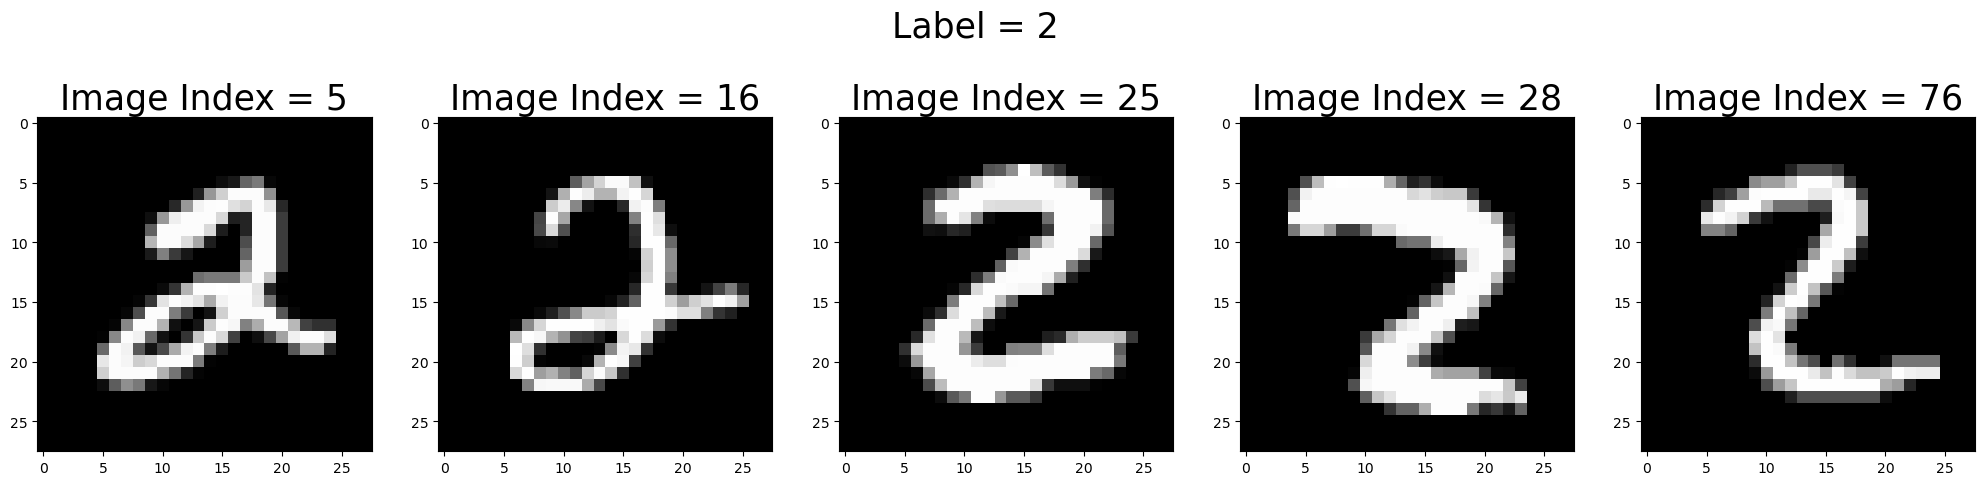

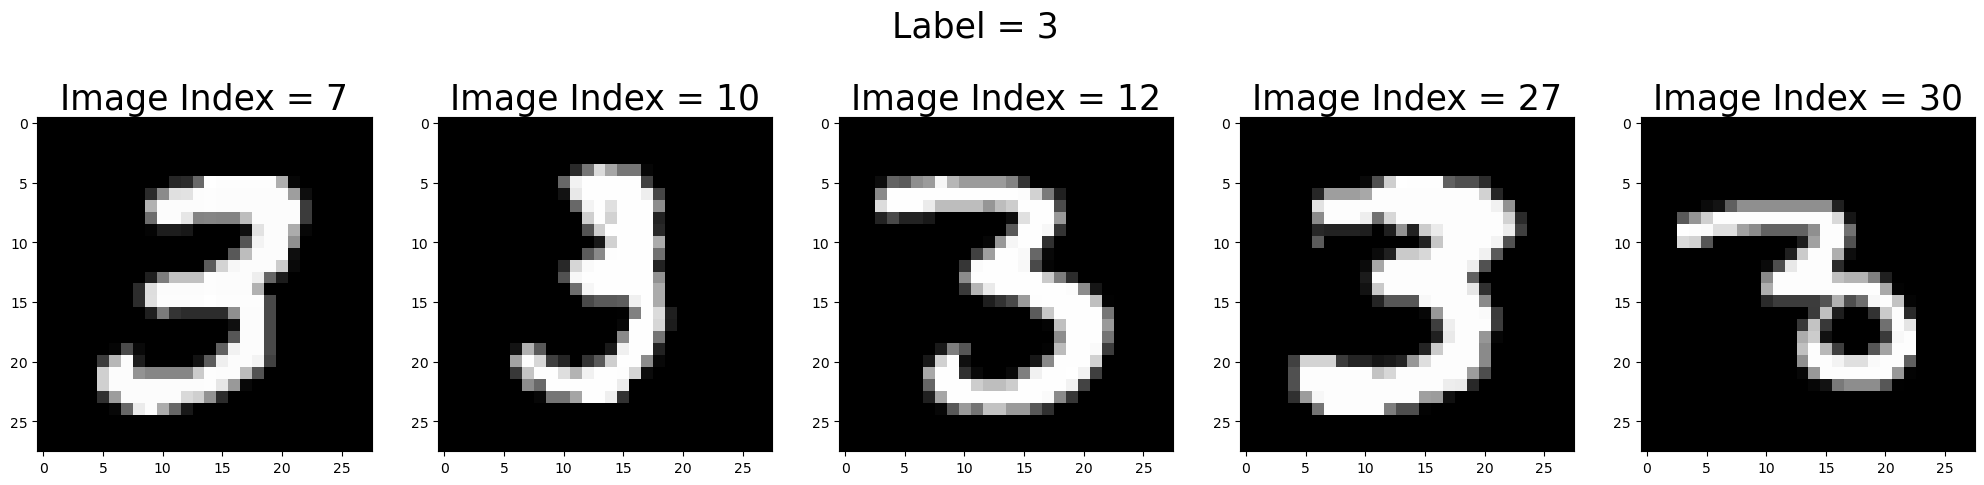

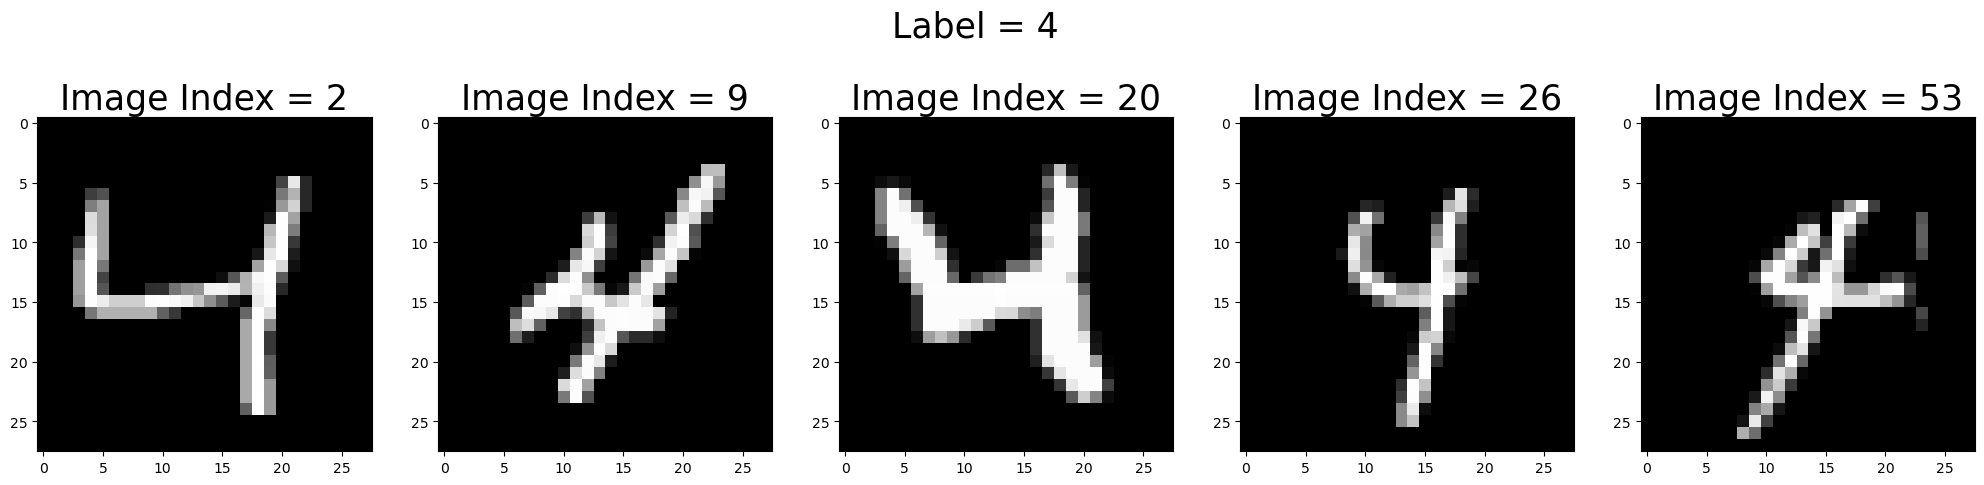

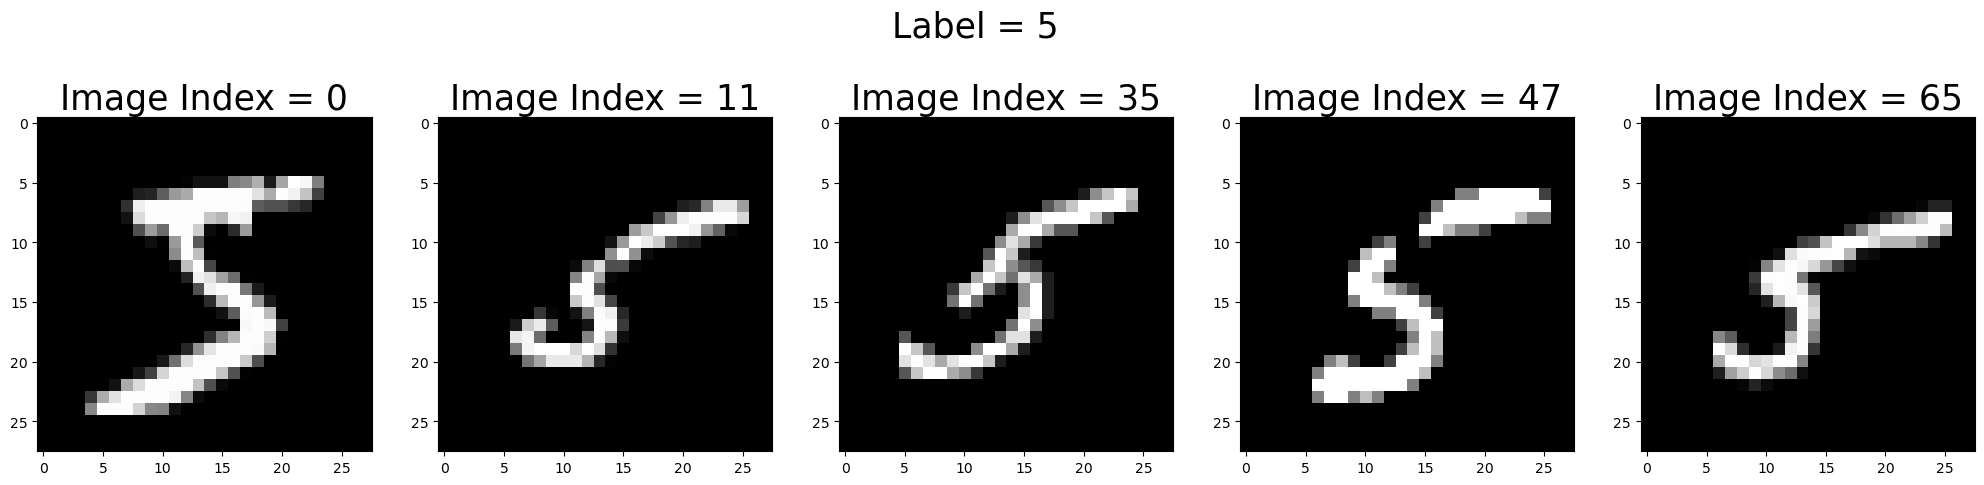

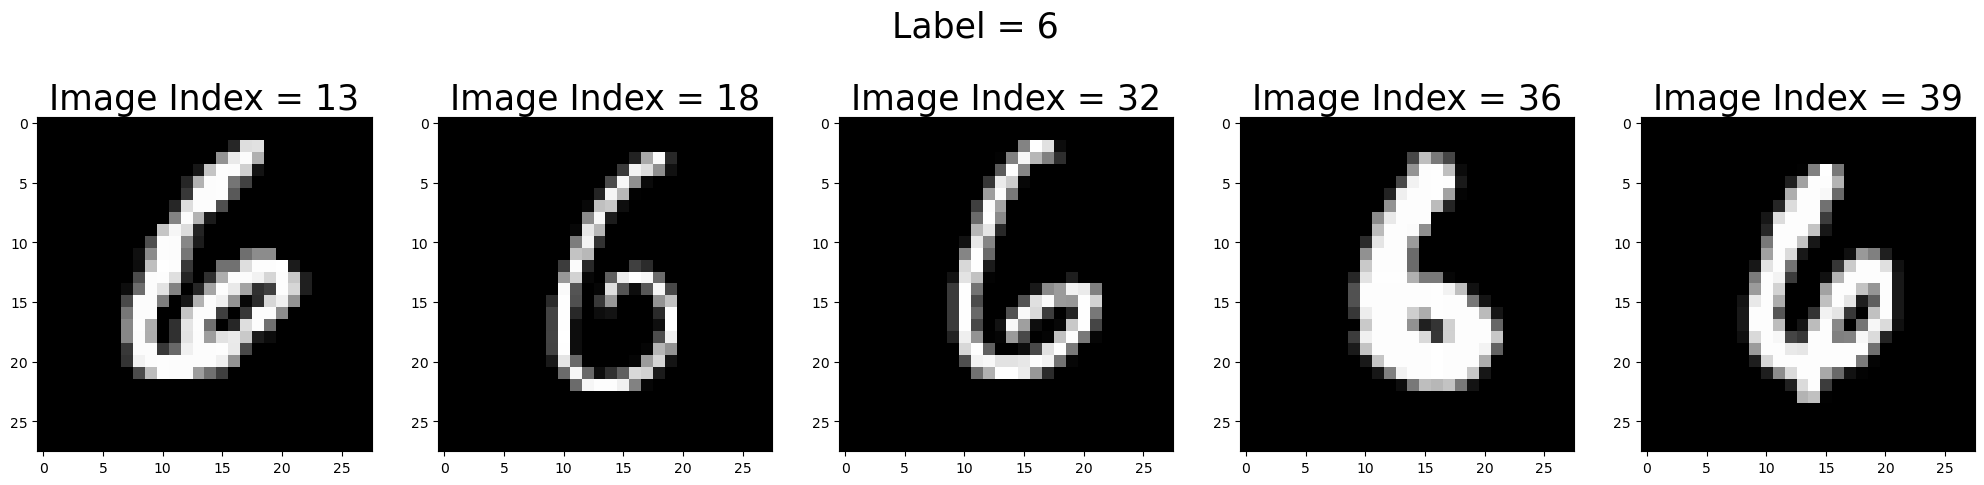

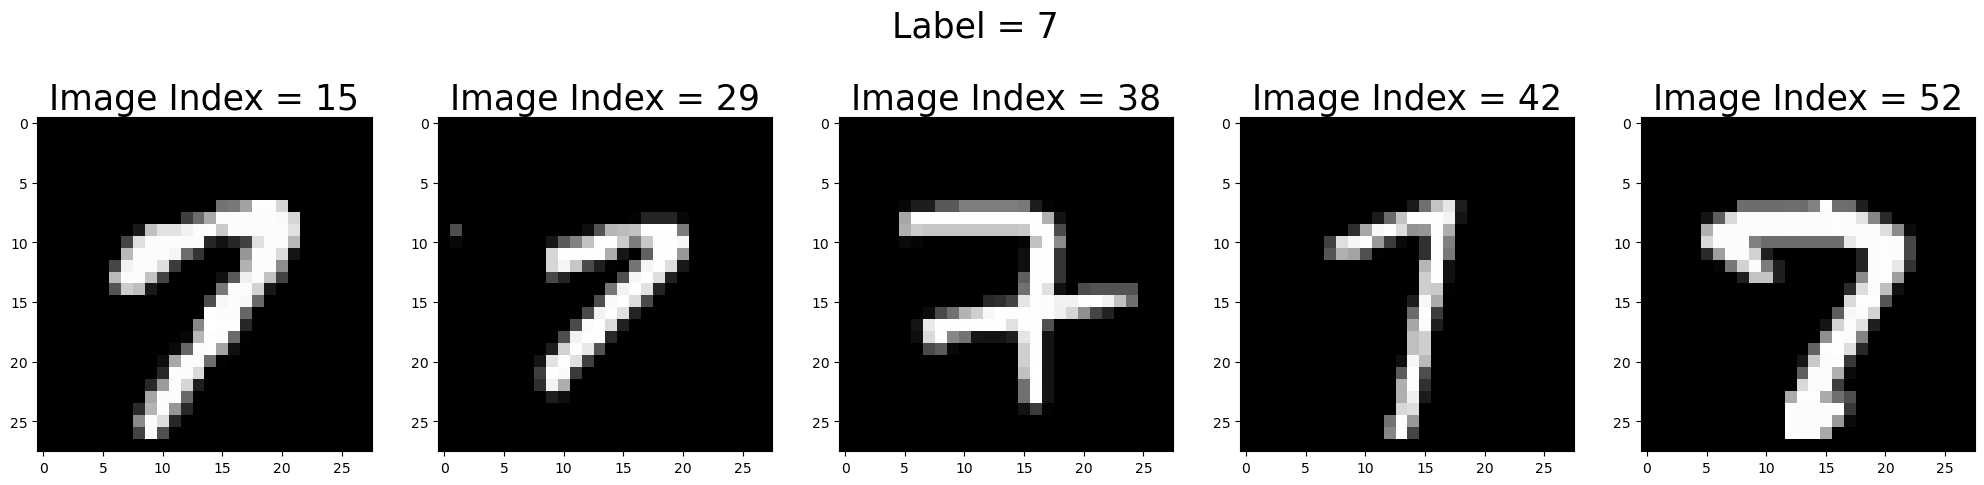

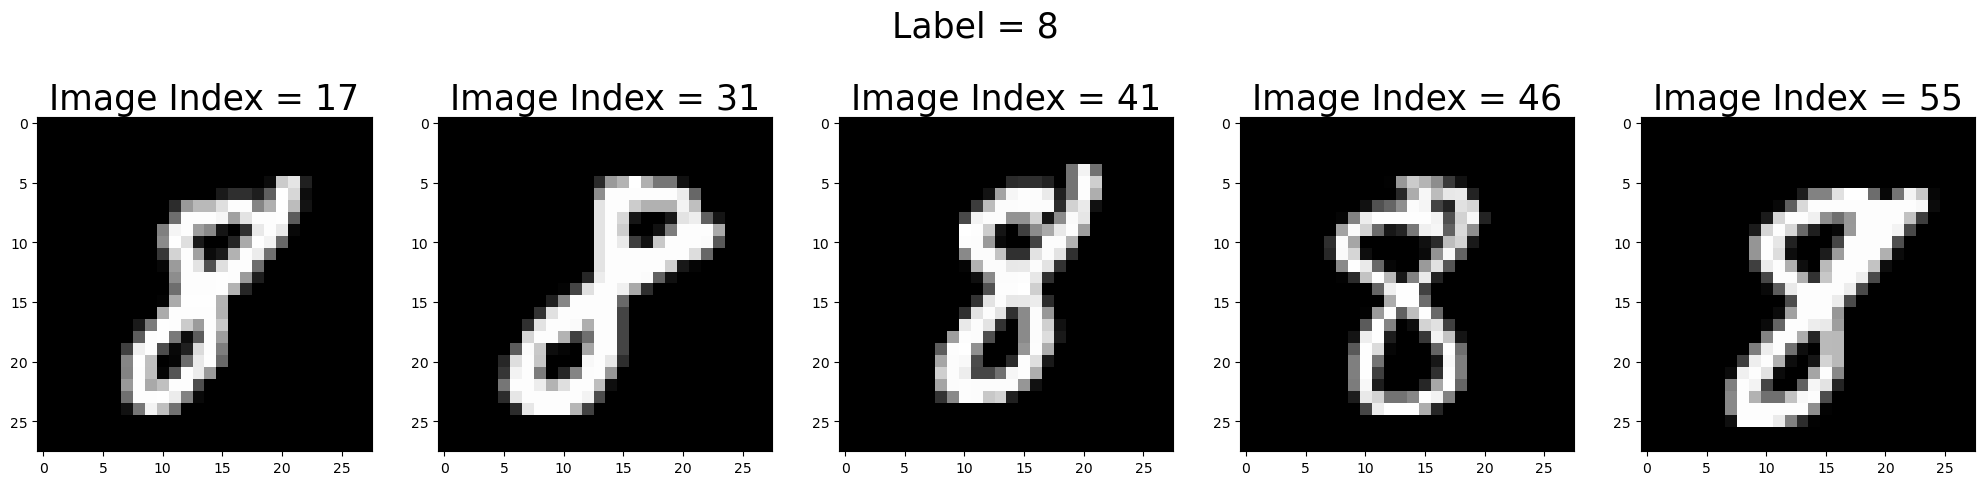

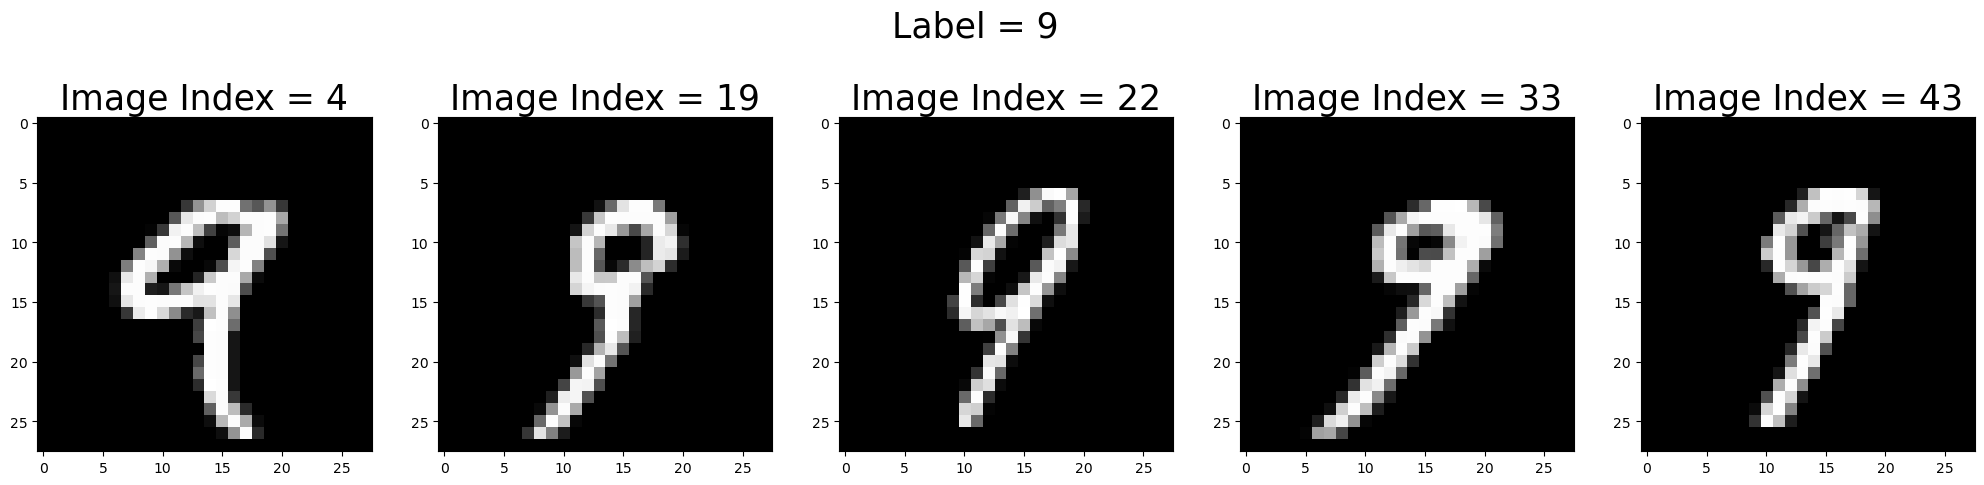

In [9]:
subplot_n_images_from_dataset(images_class_dict, 5, 'gray')

### 1.2 - 1.3 - Create New Dataset

**First I'll create and save the new images to a CSV file**

In [10]:
def parse_new_number(new_number: int) -> tuple:
    hundreds = new_number // 100
    tens = (new_number // 10) % 10
    digits = new_number % 10

    return hundreds, tens, digits


def create_new_single_number(new_number: int, num_samples: int, root_dir: str, replace: bool=True) -> pd.DataFrame:
    df = pd.DataFrame(columns=['image_name', 'label'])
    image_prefix = 'num_img_'
    hundreds, tens, digits = parse_new_number(new_number)

    hundreds_images_keys = list(map(int, images_class_dict[hundreds].keys()))
    tens_images_keys = list(map(int, images_class_dict[tens].keys()))
    digits_images_keys = list(map(int, images_class_dict[digits].keys()))

    hundreds_chosen = np.random.choice(hundreds_images_keys, num_samples, replace=replace)
    tens_chosen = np.random.choice(tens_images_keys, num_samples, replace=replace)
    digits_chosen = np.random.choice(digits_images_keys, num_samples, replace=replace)
    
    for hundreds_image_index, tens_image_index, digit_image_index in zip(hundreds_chosen, tens_chosen, digits_chosen):
        # Get random hundreds image
        hundreds_image = images_class_dict[hundreds][hundreds_image_index]
        # Get random tens image
        tens_image = images_class_dict[tens][tens_image_index]
        # Get random digits image
        digit_image = images_class_dict[digits][digit_image_index]
        # Create new 3 digit image
        new_image = np.concatenate([hundreds_image, tens_image, digit_image], axis=1)
        new_image = np.concatenate([np.zeros_like(new_image), new_image, np.zeros_like(new_image)], axis=0)
        # Create new image name
        image_name = f"{image_prefix}_{hundreds_image_index}_{tens_image_index}_{digit_image_index}.jpg"
        # Save image detailes to data frame
        df.loc[len(df)] = [image_name, new_number]
        # Save image to dataset
        image_path = os.path.join(root_dir, image_name)
        cv2.imwrite(image_path, new_image)

    return df


def create_new_numbers(num_classes:int, num_samples: int, root_dir: str, replace: bool=True) -> pd.DataFrame:
    new_num_df = pd.DataFrame(columns=['image_name', 'label'])

    for i in range(num_classes):
        temp_df = create_new_single_number(i, num_samples, root_dir)
        new_num_df = pd.concat([new_num_df, temp_df])

    return new_num_df.reset_index(drop=True)


def create_dict_from_data_frame(data_frame: pd.DataFrame) -> dict:
    new_object_dict = data_frame.reset_index().to_dict('index')
    new_object_dict = {k: v['image'] for k, v in new_object_dict.items()}

    return new_object_dict


def create_new_objects_csv(data_frame: pd.DataFrame, file_path: str='Data/new_nums.csv') -> str:
    new_objects_csv = data_frame.to_csv(file_path)
    
    return new_objects_csv

In [11]:
numbers_data_file_path = os.path.join('Data', 'mnist100_csv.csv')
numbers_root_dir = os.path.join('Data', 'MNIST100')

if not os.path.exists(numbers_root_dir):
    os.makedirs(numbers_root_dir)
    new_nums_data_frame = create_new_numbers(101, 4000, numbers_root_dir, False)
    create_new_objects_csv(new_nums_data_frame, numbers_data_file_path)

**Creating the Dataset**

In [12]:
class MNIST100(Dataset):
    """ MNIST100 classes dataset. """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.numbers_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self) -> int:
        return len(self.numbers_frame)

    def __getitem__(self, idx) -> dict:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.numbers_frame.iloc[idx, 1])
        label = self.numbers_frame.iloc[idx, 2]
        image = io.imread(img_name, cv2.IMREAD_GRAYSCALE)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [13]:
mnist100_dataset = MNIST100(csv_file=numbers_data_file_path,
                            root_dir=numbers_root_dir)

### 1.4 - Dataset Augmentations

In [14]:
base_image_index = 8123
base_image = mnist100_dataset[base_image_index]['image']
base_images_dict = {0: base_image}

**Augmentations with Gaussian Noise**

In [15]:
def add_guassian_noise(base_img: np.ndarray, mean: float, sigma: float) -> np.ndarray:
    noise_kernel = np.random.normal(loc=mean, scale=sigma, size=base_img.shape)
    noised_image = base_img + noise_kernel
    return noised_image, noise_kernel


def create_noisy_images(base_img: np.ndarray, mean: list, sigma_values: float) -> dict[np.ndarray]:
    all_noisy_images = {}

    for sigma in (sigma_values):
        noised_image, kernel = add_guassian_noise(base_img=base_img, mean=mean, sigma=sigma)
        all_noisy_images[sigma] = noised_image

    return all_noisy_images, kernel


def save_augumented_images(root_dir: str, images_dict: dict[np.ndarray], base_image_index: int, name_prefix: str):
    for i, (k, img) in enumerate(images_dict.items()):
        if i != 0:
            image_name = f'{name_prefix}_num_img_{base_image_index}_{k}.jpg'
            image_path = os.path.join(root_dir, image_name)
            cv2.imwrite(image_path, img)

In [16]:
mean = 0
sigma_values = [x for x in range(10, 25, 5)]
noise_img_name_prefix = 'noisy'

noise_augmentated_images = copy(base_images_dict)
noise_augmentated_images.update(create_noisy_images(base_image, mean, sigma_values)[0])

**Plot and save augmented images**

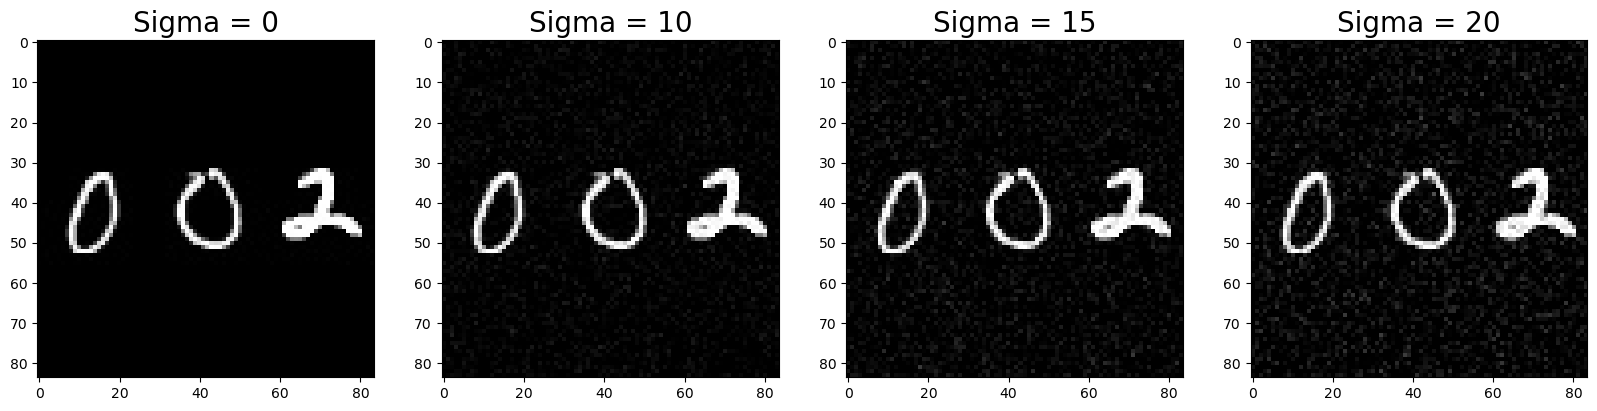

In [17]:
subplot_images(noise_augmentated_images, 4, 'gray', 'Sigma = ')
save_augumented_images(numbers_root_dir, noise_augmentated_images, base_image_index, noise_img_name_prefix)

**Augmentations with Rotation**

In [18]:
def image_rotate(img: np.ndarray, angles: list) -> dict:
    rotated_images_dict = {}
    height, width = img.shape[:2]
    center = (height // 2, width // 2)

    for a in angles:
        rotation_matrix = cv2.getRotationMatrix2D(center, a, scale=1)
        rotated_image = cv2.warpAffine(img, rotation_matrix, (height, width))
        rotated_images_dict[a] = rotated_image

    return rotated_images_dict

In [19]:
rotation_angles = [45, 90, 120]
rotated_image_prefix = 'rotated'

rotated_augmentated_images = copy(base_images_dict)
rotated_augmentated_images.update(image_rotate(base_image, rotation_angles))

**Plot and save augmented images**

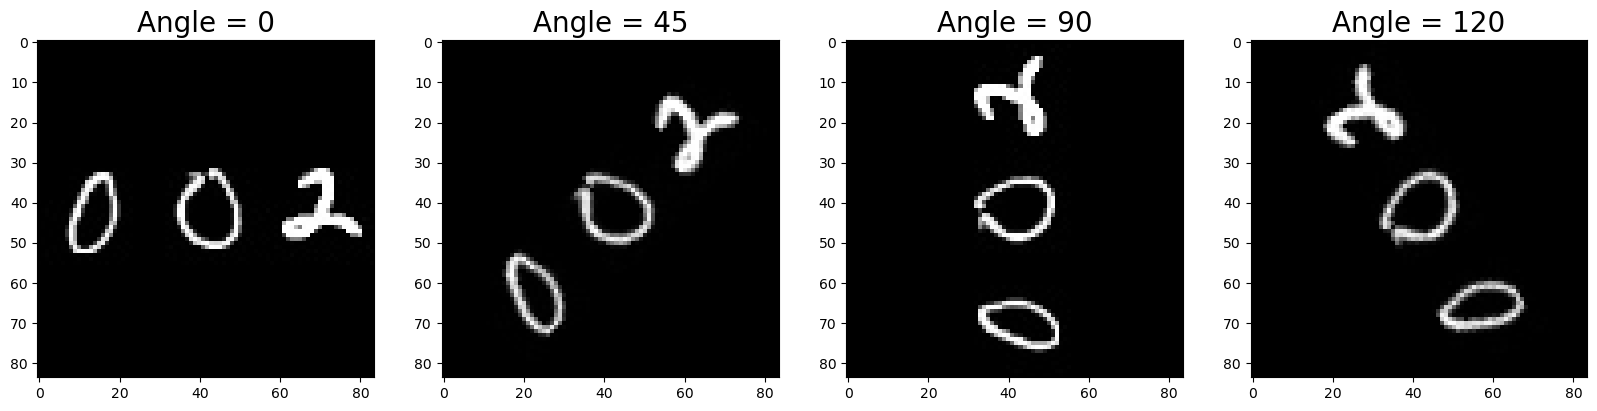

In [20]:
subplot_images(rotated_augmentated_images, 4, 'gray', 'Angle = ')
save_augumented_images(numbers_root_dir, rotated_augmentated_images, base_image_index, rotated_image_prefix)

**Augmentations with Brightness**

In [21]:
def add_brightness(img: np.ndarray, brightness_values: list) -> dict:
    bright_images_dict = {}

    for b_value in brightness_values:
        bright_image = cv2.add(img, b_value)
        bright_images_dict[b_value] = bright_image

    return bright_images_dict

In [22]:
brightness_values = [50, 100, 200]
bright_image_prefix = 'bright'

brightened_augmentated_images = copy(base_images_dict)
brightened_augmentated_images.update(add_brightness(base_image, brightness_values))

**Plot and save augmented images**

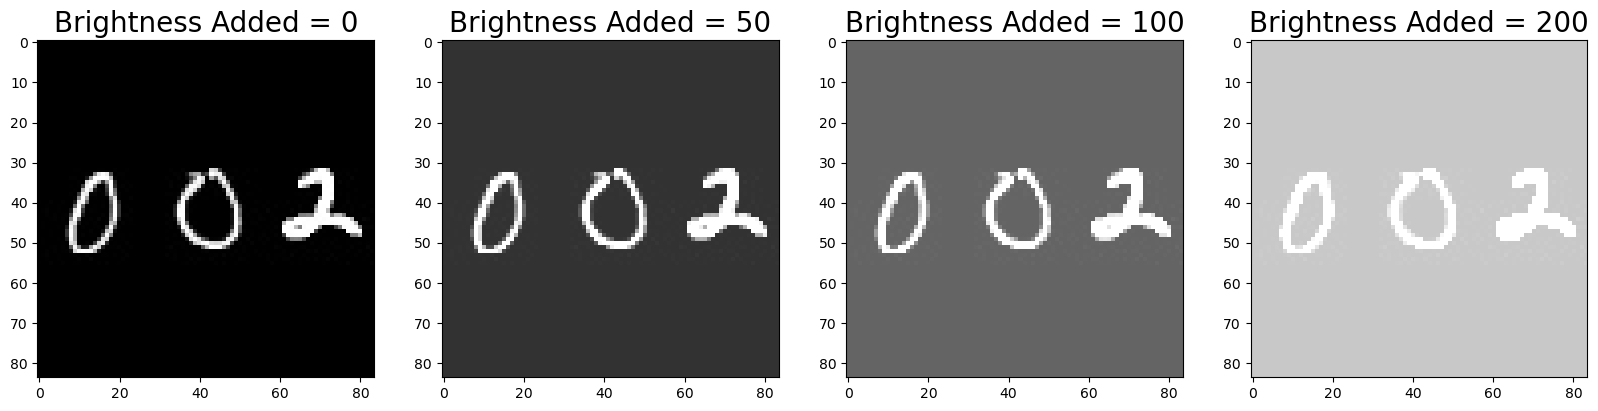

In [23]:
subplot_images(brightened_augmentated_images, 4, 'gray', 'Brightness Added = ')
save_augumented_images(numbers_root_dir, brightened_augmentated_images, 
                       base_image_index, bright_image_prefix)

**Augmentations with Flipping**

In [24]:
def flip_images(img: np.ndarray, flip_codes: dict) -> dict:
    flip_images_dict = {}

    for t, f_code in flip_codes.items():
        flipped_image = cv2.flip(img, f_code)
        flip_images_dict[t] = flipped_image

    return flip_images_dict

In [25]:
flip_codes = {
    'X': 0,
    'Y': 1,
    'X & Y': -1
}

flip_image_prefix = 'flip'

flipped_augmentated_images = copy(base_images_dict)
flipped_augmentated_images.update(flip_images(base_image, flip_codes))

**Plot and save augmented images**

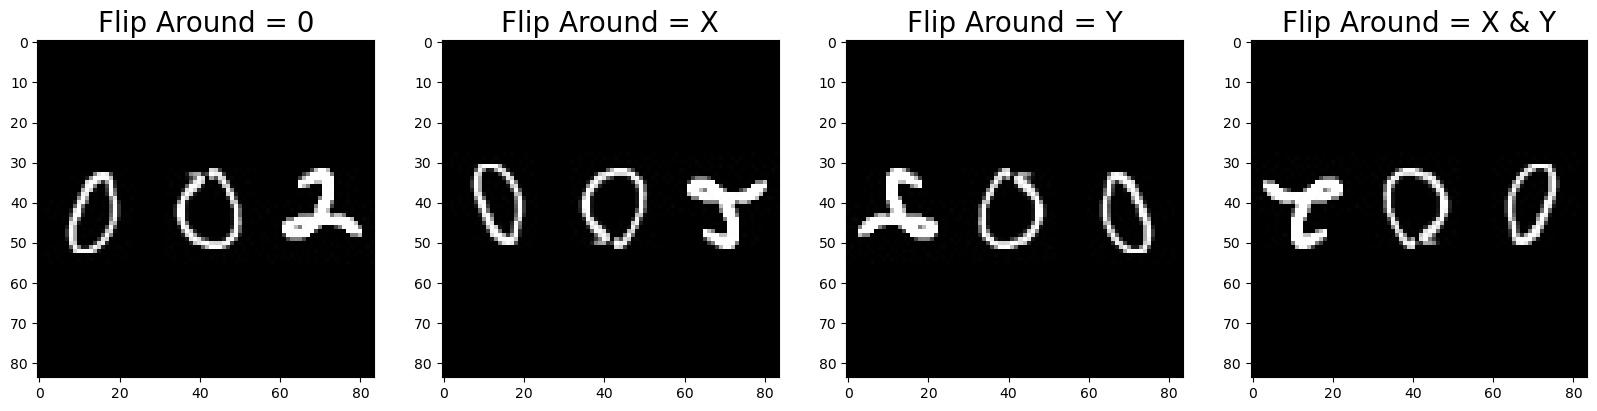

In [26]:
subplot_images(flipped_augmentated_images, 4, 'gray', 'Flip Around = ')
save_augumented_images(numbers_root_dir, flipped_augmentated_images, 
                       base_image_index, flip_image_prefix)

**Augmentations with Sharpening**

In [27]:
def sharpen_image(img: np.ndarray, kernels: dict) -> dict:
    shaprened_images_dict = {}

    for kernel_type, kernel in kernels.items():
        sharpened_image = cv2.filter2D(img, -1, kernel)
        shaprened_images_dict[kernel_type] = sharpened_image

    return shaprened_images_dict

In [28]:
laplacian = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

sobelX = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype=int)

sobelY = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype=int)

kernels = {
    'laplacian': laplacian,
    'sobelX': sobelX,
    'sobelY': sobelY
}

shaprened_image_prefix = 'sharpen'

shaprened_augmentated_images = copy(base_images_dict)
shaprened_augmentated_images.update(sharpen_image(base_image, kernels))

**Plot and save augmented images**

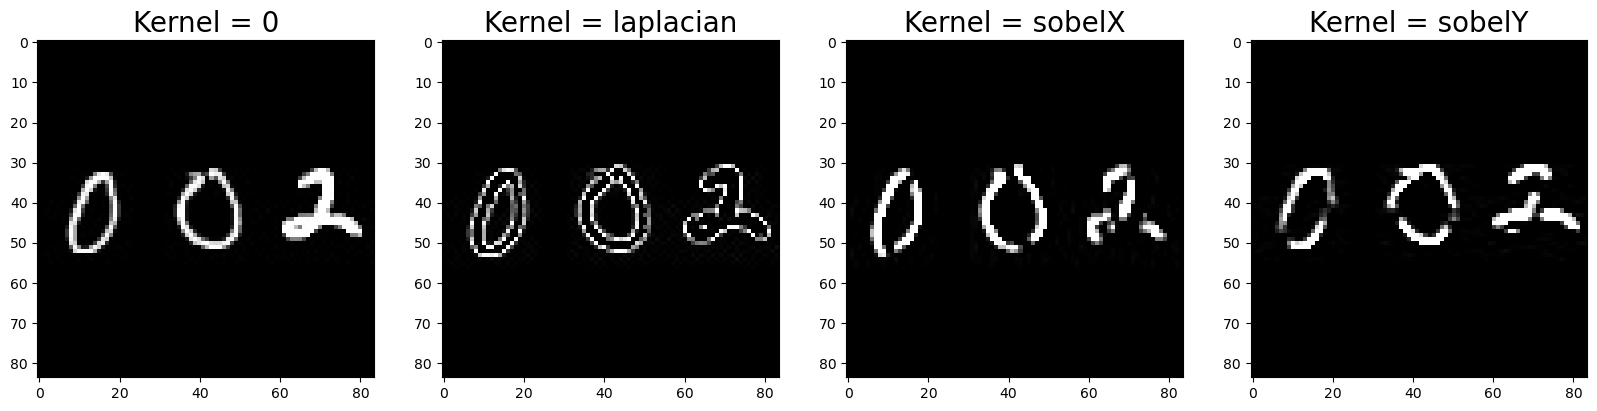

In [29]:
subplot_images(shaprened_augmentated_images, 4, 'gray', 'Kernel = ')
save_augumented_images(numbers_root_dir, shaprened_augmentated_images, 
                       base_image_index, shaprened_image_prefix)

**Data Augmentation Conclusions**

* Certain data augmentation techniques are suitable for the MNIST100 dataset because they preserve the original shape of the numbers and do not transform them into other numbers or unrelated shapes. For instance, adding Gaussian noise, rotation within the range of [-90, 90], adding brightness, and sharpening are applicable to MNIST100.

* On the other hand, some data augmentation techniques like flipping and rotation within the range of [90, 270] are not suitable for the MNIST100 dataset. These techniques may result in a number being transformed into a different number or a shape that is not a number at all. Therefore, it is important to choose appropriate augmentation techniques that preserve the essential characteristics of the dataset.

### 1.5 - Samples of the Dataset

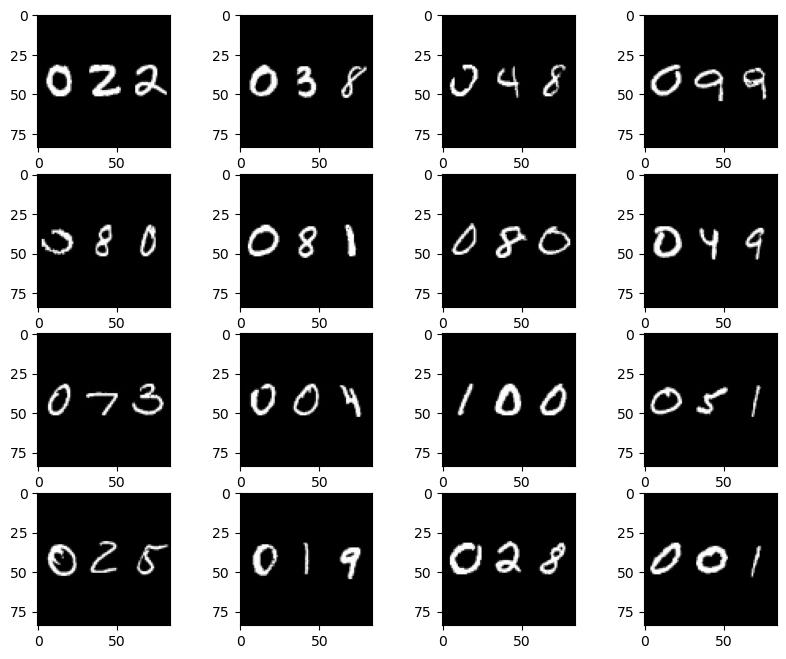

In [30]:
dataloader = DataLoader(dataset=mnist100_dataset, 
                        batch_size=16,
                        shuffle=True)

for i, batch in enumerate(dataloader):
    sample = batch
    break

sample_images = {labels: images for images, labels in zip(sample['image'], sample['label'])}
subplot_images(sample_images, 4, 'gray', fig_size=(10, 10))

# Shapes

In [31]:
# Define function to create a random color
def random_color():
    return (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))


def generate_random_circle_center(radius: float, size: int=50):
    min_center = radius + 1
    max_center = size - radius - 1
    x_center = np.random.randint(min_center, max_center)
    y_center = np.random.randint(min_center, max_center)

    return x_center, y_center



def generate_random_rectangle_center(height, width, size):
    min_x = min(height // 2 + 1, size - height // 2 - 1)
    max_x = max(height // 2 + 1, size - height // 2 - 1)

    min_y = min(width // 2 + 1, size - width // 2 - 1)
    max_y = max(width // 2 + 1, size - width // 2 - 1)

    x = np.random.randint(min_x, max_x + 1)
    y = np.random.randint(min_y, max_y + 1)

    return x, y



def generate_random_rectangle_shape(size: int=50, min_area: int=100, max_area: int=600):
    max_width = min(size, int(np.sqrt(max_area)))
    min_width = max(1, int(np.sqrt(min_area)))
    if min_width > max_width:
        # min_area is too high for the given size limit, so return the maximum possible rectangle shape
        x = max_width
        y = min(size, max_area//x)
    else:
        x = np.random.randint(min_width, max_width+1)
        max_height = min(size, max_area//x)
        min_height = min(size, min_area//x)
        if min_height > max_height:
            # min_area is too high for the given size limit and chosen width, so return the maximum possible rectangle shape for the chosen width
            y = max_height
        else:
            y = np.random.randint(min_height, max_height+1)
    return x, y



def generate_random_radius(size: int=50, min_area: int=100, max_area: int=600):
    min_r = round(np.sqrt(min_area / np.pi)) + 1
    max_r = round(np.sqrt(max_area / np.pi)) - 1
    r = np.random.randint(min_r, min(max_r, size))
    return r



def generate_random_triangle_vertices(center: tuple, img_size: tuple=(50, 50) ,min_area: int=100, max_area: int=600):
    min_size = math.sqrt(2*min_area*2/math.sqrt(3))   # calculate min_size to achieve min area of 100 pixels
    max_size = math.sqrt(2*max_area*2/math.sqrt(3))  # calculate max_size to achieve max area of 600 pixels

    size = random.uniform(min_size, max_size)

    x, y = center
    height = size * math.sqrt(3) / 2
    offset = size / 2

    # calculate the x and y bounds of the triangle
    min_x = size/2
    max_x = img_size[0] - size/2
    min_y = 2*height/3
    max_y = img_size[1] - height/3

    # choose random x and y values within the bounds of the triangle
    rand_x = random.uniform(max(min_x-x, -offset), min(max_x-x, offset))
    rand_y = random.uniform(max(min_y-y, -height/3), min(max_y-y, 2*height/3))

    # calculate the vertices of the triangle
    v1 = (int(x - size/2 + rand_x), int(y + height/3 + rand_y))

    rand_x = random.uniform(max(min_x-x, -offset), min(max_x-x, offset))
    rand_y = random.uniform(max(min_y-y, -height/3), min(max_y-y, 2*height/3))
    v2 = (int(x + size/2 + rand_x), int(y + height/3 + rand_y))

    rand_x = random.uniform(max(min_x-x, -offset), min(max_x-x, offset))
    rand_y = random.uniform(max(min_y-y, -2*height/3), min(max_y-y, height/3))
    v3 = (int(x + rand_x), int(y - 2*height/3 + rand_y))

    return (v1, v2, v3)


## Shapes Creation

#### Circle Creation

In [32]:
def create_circle_image(radius: float, center: tuple, size: int, color: tuple) -> np.ndarray:
    img = np.zeros((size, size, 3), dtype=np.uint8)

    x = np.arange(0, size, 1)
    y = np.arange(0, size, 1)
    xx, yy = np.meshgrid(x, y)

    r = np.sqrt((xx - center[0])**2 + (yy - center[1])**2)

    for i in range(3):
        img[:, :, i] = np.where(r < radius, color[i], img[:, :, i])

    return img

#### Rectangle Creation

In [33]:
def create_rectangle_image(height: int, width: int, center: tuple, size: int, color: tuple) -> np.ndarray:
    img = np.zeros((size, size, 3), dtype=np.uint8)

    x = np.arange(0, size, 1)
    y = np.arange(0, size, 1)
    xx, yy = np.meshgrid(x, y)  

    x_start = center[1] - width // 2
    y_start = center[0] - height // 2
    x_end = x_start + height
    y_end = y_start + width

    condition = (xx >= x_start) & (xx <= x_end) & (yy >= y_start) & (yy <= y_end)

    for i in range(3):
        img[:, :, i] = np.where(condition, color[i], img[:, :, i])

    return img

#### Triangle Creation

In [34]:
def DDA(img: np.ndarray, p1: tuple, p2: tuple, color: tuple) -> np.ndarray:
    x0, y0 = p1
    x1, y1 = p2

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    if x0 < x1:
        x_inc = 1
    else:
        x_inc = -1
    if y0 < y1:
        y_inc = 1
    else:
        y_inc = -1

    x = x0
    y = y0

    x_coordinates = []
    y_coordinates = []

    if dx > dy:
        steps = dx
        error = dx / 2
        for i in range(steps):
            x_coordinates.append(x)
            y_coordinates.append(y)

            error -= dy
            if error < 0:
                y += y_inc
                error += dx

            x += x_inc

    else:
        steps = dy
        error = dy / 2
        for i in range(steps):
            x_coordinates.append(x)
            y_coordinates.append(y)

            error -= dx
            if error < 0:
                x += x_inc
                error += dy

            y += y_inc

    for i in range(steps):
        img[round(x_coordinates[i]), round(y_coordinates[i])] = color

    return img


def create_triangle_image(vertices: tuple, size: int, color: tuple) -> np.ndarray:
    v1, v2, v3 = sorted(vertices)
    img = np.zeros((size, size, 3), dtype="uint8")

    img = DDA(img, v1, v2, color)
    img = DDA(img, v2, v3, color)
    img = DDA(img, v1, v3, color)

    return img



def create_triangle_image_cv2(vertices: tuple, size: int, color: tuple) -> np.ndarray:
    v1, v2, v3 = vertices
    img = np.zeros((size, size, 3), dtype="uint8")

    img = cv2.line(img, v1, v2, color)
    img = cv2.line(img, v2, v3, color)
    img = cv2.line(img, v3, v1, color)

    mask = np.zeros((size, size), dtype="uint8")
    cv2.drawContours(mask, [np.array([v1, v2, v3])], -1, 255, -1)

    img = np.where(mask[:, :, np.newaxis] == 255, color, img)

    return img

## Shapes Dataset Creation

In [35]:
def create_shapes_circle(num_samples: int, root_dir: str, size: int = 50, min_area: int = 100, max_area: int = 600) -> pd.DataFrame:
    df = pd.DataFrame(columns=['image_name', 'label'])
    image_prefix = 'shape_img_'

    for _ in range(num_samples):
        color = random_color()
        radius = generate_random_radius(size, min_area, max_area)
        center = generate_random_circle_center(radius, size)
        circle = create_circle_image(radius, center, size, color)

        # Create new image name
        image_name = f"{image_prefix}_{color}_{radius}_{center}.jpg"
        # Save image detailes to data frame
        df.loc[len(df)] = [image_name, 'circle']
        # Save image to dataset
        image_path = os.path.join(root_dir, image_name)
        cv2.imwrite(image_path, circle)
    return df



def create_shapes_rectangle(num_samples: int, root_dir: str, size: int = 50, min_area: int = 100, max_area: int = 600) -> pd.DataFrame:
    df = pd.DataFrame(columns=['image_name', 'label'])
    image_prefix = 'shape_img_'

    for _ in range(num_samples):
        height, width = generate_random_rectangle_shape(size, min_area, max_area)
        center = generate_random_rectangle_center(height, width, size)
        color = random_color()

        rectangle = create_rectangle_image(height, width, center, size, color)

        # Create new image name
        image_name = f"{image_prefix}_{color}_{height}_{width}_{center}.jpg"
        # Save image detailes to data frame
        df.loc[len(df)] = [image_name, 'rectangle']
        # Save image to dataset
        image_path = os.path.join(root_dir, image_name)
        cv2.imwrite(image_path, rectangle)
    return df



def create_shapes_triangle(num_samples: int, root_dir: str, size: int = 50, min_area: int = 100, max_area: int = 600) -> pd.DataFrame:
    df = pd.DataFrame(columns=['image_name', 'label'])
    image_prefix = 'shape_img_'

    for _ in range(num_samples):
        color = random_color()
        radius = generate_random_radius(size, min_area, max_area)
        center = generate_random_circle_center(radius, size)
        vertices = generate_random_triangle_vertices(center, (size, size), min_area, max_area)

        triangle = create_triangle_image(vertices, size, color)

        # Create new image name
        image_name = f"{image_prefix}_{color}_{radius}_{center}.jpg"
        # Save image detailes to data frame
        df.loc[len(df)] = [image_name, 'triangle']
        # Save image to dataset
        image_path = os.path.join(root_dir, image_name)
        cv2.imwrite(image_path, triangle)
    return df



def create_shapes_triangle_with_cv2(num_samples: int, root_dir: str, size: int = 50, min_area: int = 100, max_area: int = 600) -> pd.DataFrame:
    df = pd.DataFrame(columns=['image_name', 'label'])
    image_prefix = 'cv2_shape_img_'

    for _ in range(num_samples):
        color = random_color()
        radius = generate_random_radius(size, min_area, max_area)
        center = generate_random_circle_center(radius, size)
        vertices = generate_random_triangle_vertices(center, (size, size), min_area, max_area)

        triangle = create_triangle_image_cv2(vertices, size, color)

        # Create new image name
        image_name = f"{image_prefix}_{color}_{radius}_{center}.jpg"
        # Save image detailes to data frame
        df.loc[len(df)] = [image_name, 'triangle']
        # Save image to dataset
        image_path = os.path.join(root_dir, image_name)
        cv2.imwrite(image_path, triangle)
    return df




def create_new_shapes(num_samples: int, shape_creation_functions: list, root_dir: str, size: int = 50, min_area: int = 100, max_area: int = 600) -> pd.DataFrame:
    new_shapes_df = pd.DataFrame(columns=['image_name', 'label'])

    for f in shape_creation_functions:
        temp_df = f(num_samples, root_dir, size, min_area, max_area)
        new_shapes_df = pd.concat([new_shapes_df, temp_df])

    return new_shapes_df.reset_index(drop=True)



def create_dict_from_data_frame(data_frame: pd.DataFrame) -> dict:
    new_object_dict = data_frame.reset_index().to_dict('index')
    new_object_dict = {k: v['image'] for k, v in new_object_dict.items()}

    return new_object_dict



def create_new_objects_csv(data_frame: pd.DataFrame, file_path: str='Data/new_nums.csv') -> str:
    new_objects_csv = data_frame.to_csv(file_path)
    
    return new_objects_csv

**Create and Save Images (if needed)**

In [36]:
shapes_data_file_path = os.path.join('Data', 'shapes_csv.csv')
shapes_root_dir = os.path.join('Data', 'SHAPES')
num_samples = 400
shape_creation_functions = [create_shapes_circle, create_shapes_rectangle, create_shapes_triangle, create_shapes_triangle_with_cv2]

if not os.path.exists(shapes_root_dir):
    os.makedirs(shapes_root_dir)
    shapes_data_frame = create_new_shapes(num_samples, shape_creation_functions, shapes_root_dir)
    create_new_objects_csv(shapes_data_frame, shapes_data_file_path)

**Shapes Dataset Class**

In [37]:
class SHAPES(Dataset):
    """ SHAPES classes dataset. """

    def __init__(self, csv_file, root_dir, train: bool=True, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.state = train
        self.__set_labels__(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.__split__(csv_file, root_dir)
        self.shapes_frame = pd.read_csv(os.path.join(root_dir, 'train.csv')) if train else pd.read_csv(os.path.join(root_dir, 'test.csv'))


    def __set_labels__(self, csv_file):
        df = pd.read_csv(csv_file)
        # create a dictionary to map the labels to new values
        label_map = {'triangle': 0, 'rectangle': 1, 'circle': 2}
        # use the map() function to replace the labels with the new values
        df['label'] = df['label'].map(label_map)
        # save the updated dataframe to a new csv file
        df.to_csv(csv_file, index=False)


    def __split__(self, csv_file: str, root_dir: str, test_size: int=0.1):
        train_csv_path = os.path.join(root_dir, 'train.csv')
        test_csv_path = os.path.join(root_dir, 'test.csv')
        if not os.path.exists(train_csv_path):
            # read in the csv file
            df = pd.read_csv(csv_file)
            
            # shuffle the dataframe
            df_shuffled = df.sample(frac=1, random_state=42)
            
            # split the dataframe into training and test sets
            split_index = int(len(df_shuffled) * (1 - test_size))
            train_df = df_shuffled[:split_index]
            test_df = df_shuffled[split_index:]
            
            # save the training and test sets as separate CSV files
            train_df.to_csv(train_csv_path, index=False)
            test_df.to_csv(test_csv_path, index=False)


    def __len__(self) -> int:
        return len(self.shapes_frame)


    def __getitem__(self, idx) -> dict:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.shapes_frame.iloc[idx, 1])
        label = self.shapes_frame.iloc[idx, 2]
        image = io.imread(img_name, cv2.IMREAD_GRAYSCALE)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [38]:
shapes_dataset_train = SHAPES(csv_file=shapes_data_file_path, root_dir=shapes_root_dir)
shapes_dataset_test = SHAPES(csv_file=shapes_data_file_path, root_dir=shapes_root_dir, train=False)

## Images without Augmentetions

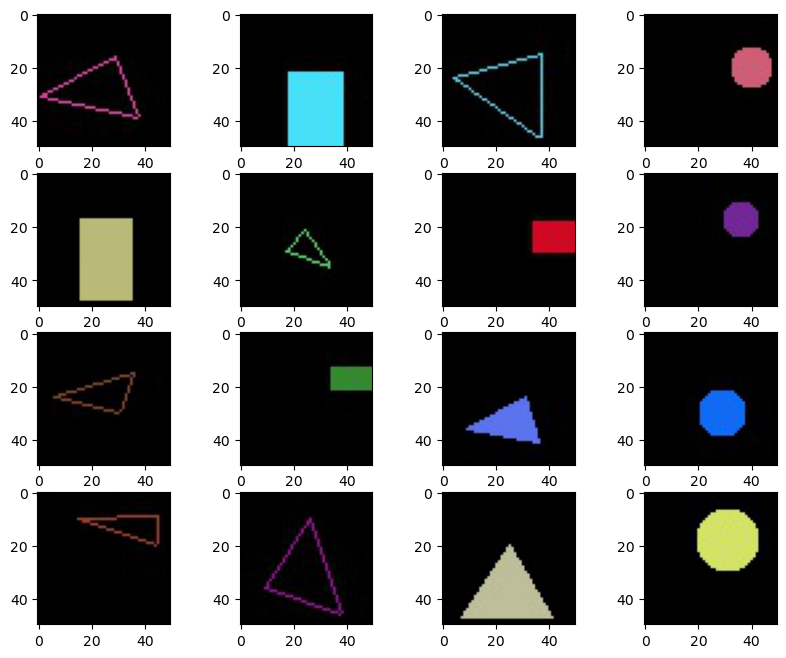

In [39]:
dataloader = DataLoader(dataset=shapes_dataset_train, 
                        batch_size=16,
                        shuffle=True)

for i, batch in enumerate(dataloader):
    sample = batch
    break

shapes_sample_images = {labels: images for images, labels in zip(sample['image'], sample['label'])}
subplot_images(shapes_sample_images, 4, fig_size=(10, 10))

## Images With Augmentations

In [40]:
base_image_index = 570
base_image = shapes_dataset_train[base_image_index]['image']
base_images_dict = {0: base_image}

**Augmentations with Gaussian noise**

In [41]:
mean = 0
sigma_values = [x for x in range(0, 12, 3)]
noise_img_name_prefix = 'noisy'

noise_augmentated_images = copy(base_images_dict)
noise_augmentated_images.update(create_noisy_images(base_image, mean, sigma_values)[0])

noise_augmentated_images = {k: i.astype("uint8") for k, i in noise_augmentated_images.items()}

**Plot and Save Augmented Images**

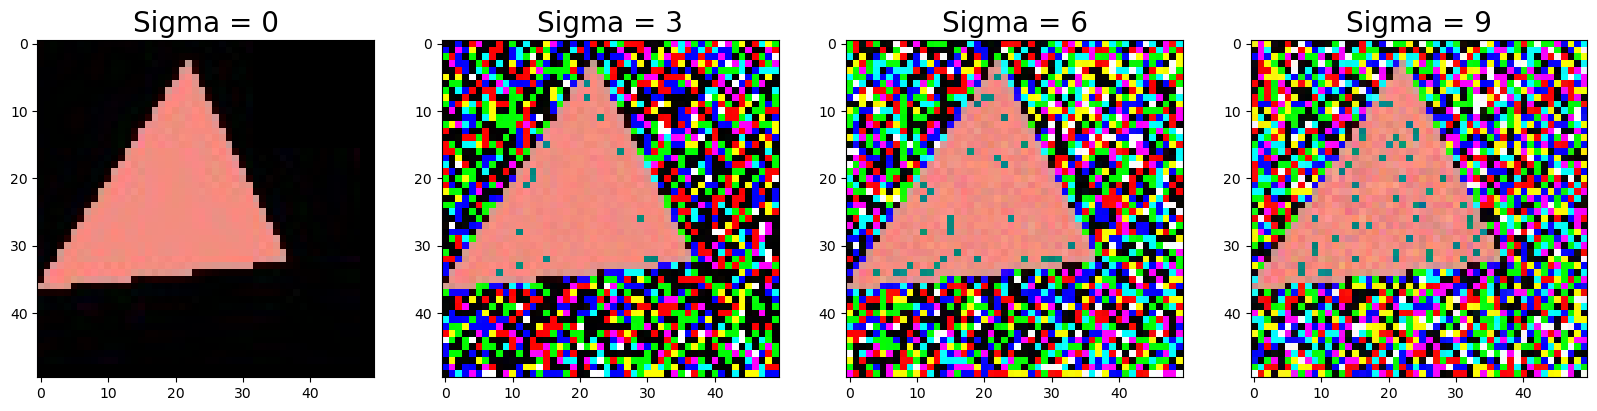

In [42]:
subplot_images(noise_augmentated_images, 4, title='Sigma = ')
save_augumented_images(shapes_root_dir, noise_augmentated_images, base_image_index, noise_img_name_prefix)

**Augmentetions with Rotation**

In [43]:
rotation_angles = [45, 90, 120]
rotated_image_prefix = 'rotated'

rotated_augmentated_images = copy(base_images_dict)
rotated_augmentated_images.update(image_rotate(base_image, rotation_angles))

**Save and Plot Augmented Images**

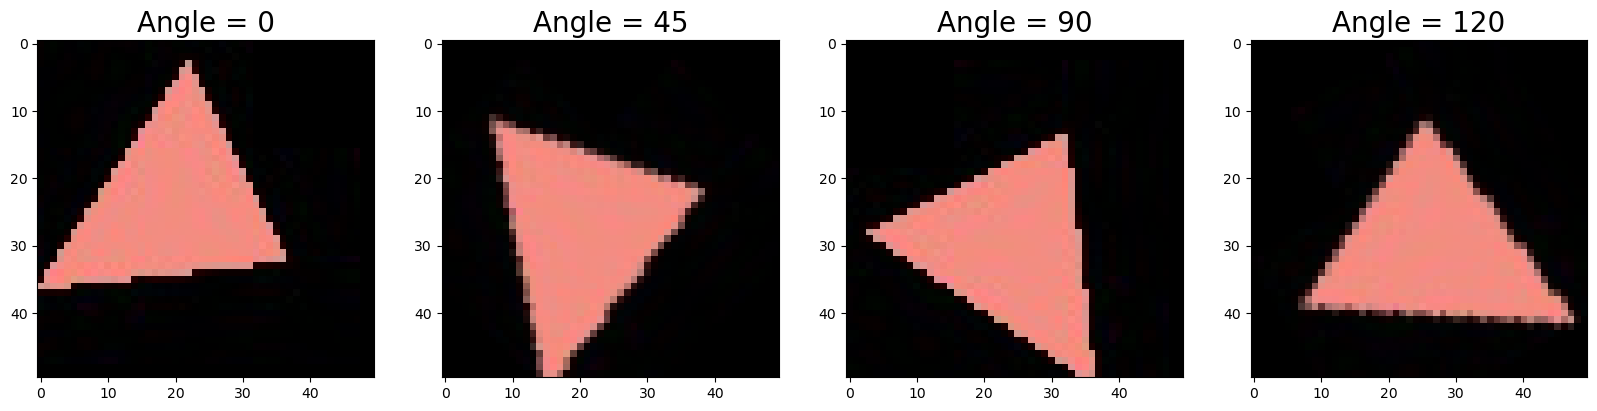

In [44]:
subplot_images(rotated_augmentated_images, 4, 'gray', 'Angle = ')
save_augumented_images(shapes_root_dir, rotated_augmentated_images, base_image_index, rotated_image_prefix)

**Augmentations with Flipping**

In [45]:
flip_codes = {
    'X': 0,
    'Y': 1,
    'X & Y': -1
}

flip_image_prefix = 'flip'

flipped_augmentated_images = copy(base_images_dict)
flipped_augmentated_images.update(flip_images(base_image, flip_codes))

**Plot and save augmented images**

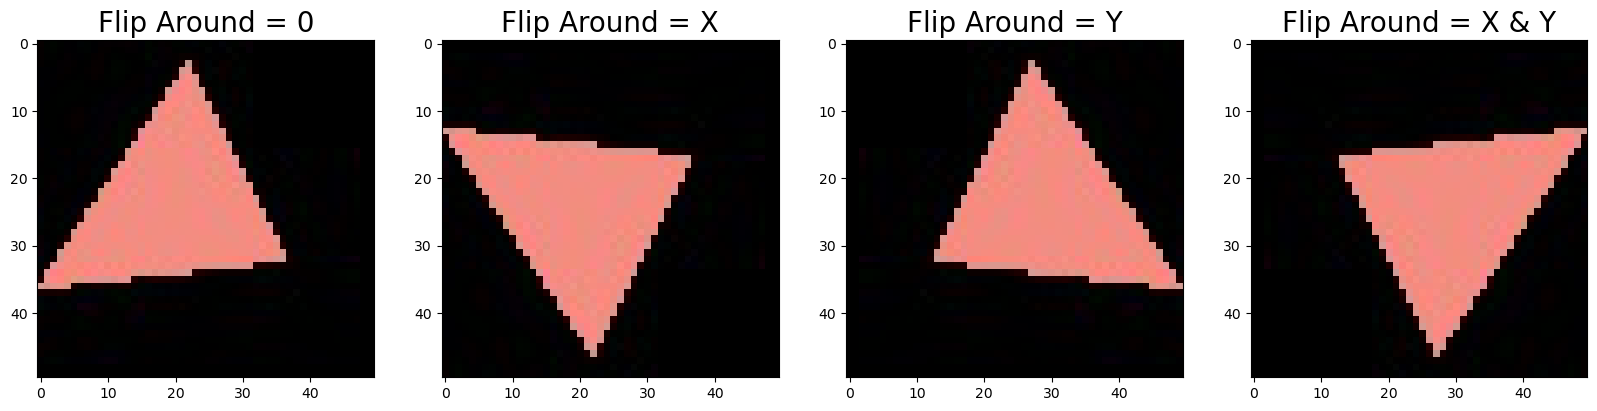

In [46]:
subplot_images(flipped_augmentated_images, 4, 'gray', 'Flip Around = ')
save_augumented_images(shapes_root_dir, flipped_augmentated_images, 
                       base_image_index, flip_image_prefix)

# Summary

## Utils Functions

At first, I wrote some utility functions:

* `plot_image()` - Plots a single image.
* `subplot_images()` - Plots multiple images, in a visually appealing way, given a dictionary of images and labels.

## MNIST100

In the first part of EX1, I created a new dataset, which I called MNIST100. This dataset includes 3-digit numbers (000 - 100), which are from the MNIST dataset.

To do that, I first created a dictionary of images and labels, where the keys are the class number of the original MNIST dataset, and the values are the matching images for each class.

Then, I created the new dataset with the following functions:

* `parse_new_number()` - Separates the digits, tens, and hundreds of a number.
* `create_new_single_number()` - Creates `num_samples` new samples for a single number, using `parse_new_number()`, and numpy array concatenations.
* `create_new_numbers()` - Calls `create_new_single_number()` for every new class we want to create.

Afterwards, I created the new images, and saved their name (which is a combination I thought of) and label in a CSV file, and wrote a class for dataset - `MNIST100`, for easy access.

At the end, I created 5 types of image augmentations, each with 3 different augmentation values - a total of 15 augmentations:

* Adding Gaussian Noise, with sigma values of 10, 15, 20.
* Rotation, with angle values of 45, 90, 120.
* Increasing brightness by 50, 100, 200.
* Flipping around X, Y, and both X & Y axes.
* Sharpening with Laplacian, SobelX, SobelY.

## Shapes

In the second part of EX1, I created the shapes creation functions from scratch:

* `create_circle_image()`
* `create_rectangle_image()`
* `create_triangle_image()`
* `create_triangle_image_cv2()`

The triangle creation was the hardest, and I didn't want to give up implementing it from scratch, but when I successfully did it, I couldn't fill the shapes, so I also wrote the same function with cv2, so I'll have both types of triangles.

Then, I had to write the following functions, so my shapes would have random size, location, orientation, color, and area size between 100 - 600 pixels:

* `random_color()`
* `generate_random_circle_center()`
* `generate_random_rectangle_center()`
* `generate_random_rectangle_shape()`
* `generate_random_radius()`
* `generate_random_rectangle_shape()`
* `generate_random_triangle_vertices()`

Afterwards, I wrote the following functions in order to create the new shapes images:

* `create_shapes_circle()` - Calls the previous matching circle functions, and creates `num_samples` new circles.
* `create_shapes_rectangle()` - Calls the previous matching rectangle functions, and creates `num_samples` new rectangles.
* `create_shapes_triangle()` - Calls the previous matching triangle functions, and creates `num_samples` new triangles.
* `create_shapes_triangle_with_cv2()` - Calls the previous matching triangle functions, and creates `num_samples` new triangles **with CV2**.

And the "master" function:

* `create_new_shapes()` - This function gets the shape creation functions (which are the previous creation functions) and calls them all for the whole Shapes dataset creation.

Then, I used the dataframe I got from `create_new_shapes()` to create a CSV file of the image names and labels, so I could use it with a dataset class. Then I wrote the `SHAPES` dataset class, which loads the matching CSV file, labels the data, and splits the data into train and test sets.

Finally, I created and plotted some augmentations:
- Adding Gaussian Noise, with sigma values of 3, 6, 9.
- Rotation, with angle values of 45, 90, 120.
- Flipping around X, Y, and both X & Y axes.


# Resources
* https://medium.com/analytics-vidhya/data-augmentation-techniques-using-opencv-657bcb9cc30b
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* I wanted to do it with Bresenham's Line Drawing Algorithm, but with no success. https://www.youtube.com/watch?v=RGB-wlatStc
* Then I used DDA algorithm: https://en.wikipedia.org/wiki/Digital_differential_analyzer_(graphics_algorithm)
* Stackoverflow
* GeekForGeeks
* OpenCV